#### Probability encoding ratio | Target guided Encoding 

These encoding is suitable for classification problems only, where the target is binary.

For each category, we calculate the mean of target=1, that is the probability of the target being 1 $( P(1) )$, and the probability of the target=0 $( P(0) )$. And then, we calculate the ratio 

$P_{ratio} = \frac{P(1)}{P(0)}$, 

and replace the categories by that ratio.

Dataset: Titanic 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
use_columns = ['cabin', 'sex', 'embarked', 'survived']

data = pd.read_csv('../datasets/titanic.csv', usecols=use_columns)
data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# let's remove obserrvations with na in embarked
data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# and we remove the observations where cabin = T
# because they are too few

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [7]:
# let's have a look at how many labels each variable has
for col in data.columns:
    print(f"{col} categories count: \n{data[col].value_counts()}")

survived categories count: 
0    808
1    498
Name: survived, dtype: int64
sex categories count: 
male      842
female    464
Name: sex, dtype: int64
cabin categories count: 
n    1014
C      94
B      63
D      46
E      41
A      22
F      21
G       5
Name: cabin, dtype: int64
embarked categories count: 
S    913
C    270
Q    123
Name: embarked, dtype: int64


**Encoding important**
We calculate the ratio $P(1)/P(0)$ using the train set, and then use those mappings in the test set.

Note that to implement this in pandas, we need to keep the target in the training set.


In [8]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (914, 4), Test: (392, 4)


**Explore original relationship between categorical variables and target**

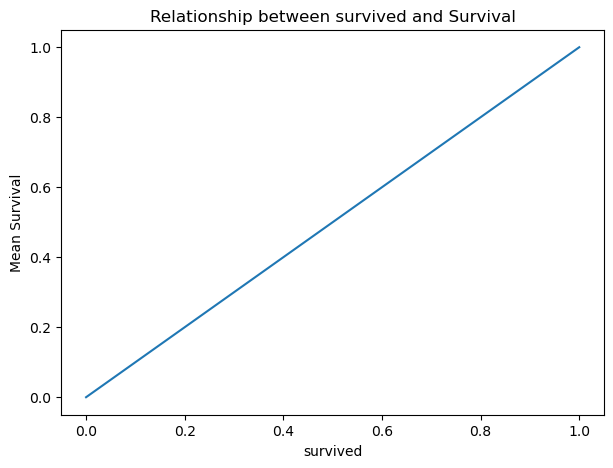

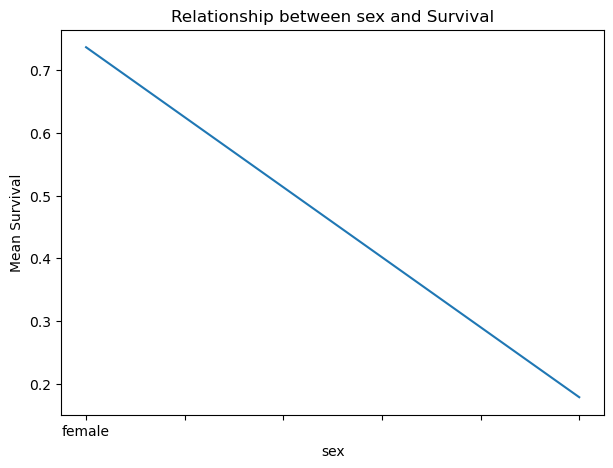

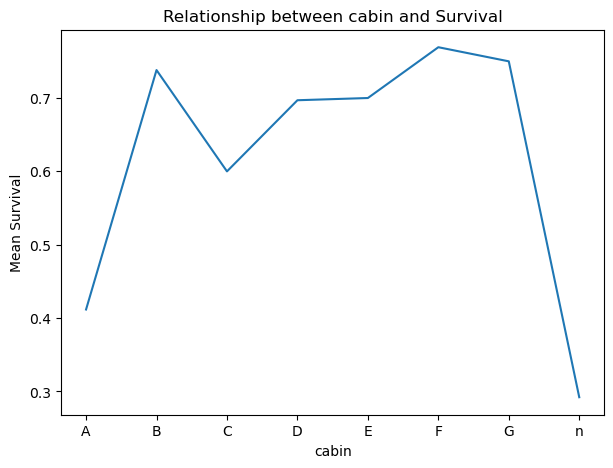

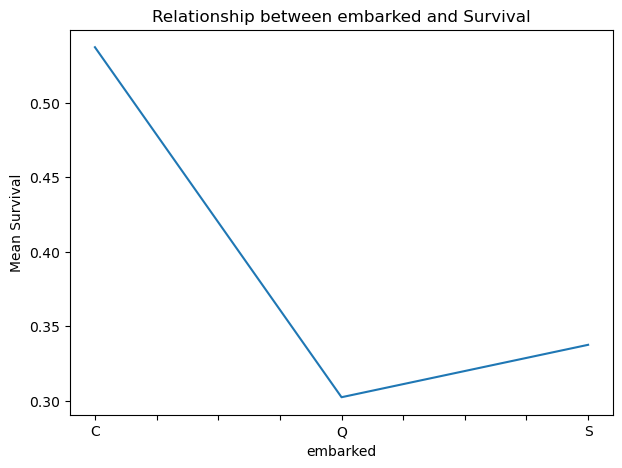

In [9]:
# let's explore the relationship of the categories with the target
for var in data.columns:
    fig = plt.figure(figsize=(7,5))
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

**Probability ratio Encoding** 

In [16]:
# let's calculate the probability of survived = 1 per category

prob_df = X_train.groupby(['cabin'])['survived'].mean()

# and capture it into a dataframe
prob_df = pd.DataFrame(prob_df)
prob_df['died'] = 1 - prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [17]:
#  and now the ratio
prob_df['ratio'] = prob_df['survived'] / prob_df['died']

prob_df

,survived,died,ratio
cabin,,,
A,0.411765,0.588235,0.700000
B,0.738095,0.261905,2.818182
C,0.600000,0.400000,1.500000
D,0.696970,0.303030,2.300000
E,0.700000,0.300000,2.333333
F,0.769231,0.230769,3.333333
G,0.750000,0.250000,3.000000
n,0.292199,0.707801,0.412826


In [18]:
# and now let's capture the ratio in a dictionary
ordered_labels = prob_df['ratio'].to_dict()
ordered_labels

{'A': 0.7,
 'B': 2.818181818181819,
 'C': 1.4999999999999998,
 'D': 2.3000000000000007,
 'E': 2.333333333333333,
 'F': 3.333333333333334,
 'G': 3.0,
 'n': 0.4128256513026052}

In [19]:
# lets create a function from above cell 

def find_category_mapping(df, variable, target):

    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    tmp['non-target'] = 1 - tmp[target]
    tmp['ratio'] = tmp[target] / tmp['non-target']
    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [20]:
for var in data.columns:
    if not var == 'survived':
        mappings = find_category_mapping(X_train, var, 'survived')
        integer_encode(X_train, X_test, var, mappings)

In [21]:
X_train.head()

,cabin,sex,embarked,survived
843,0.412826,0.218107,0.509434,0
869,0.412826,0.218107,0.509434,0
430,0.412826,2.788235,0.509434,1
481,0.412826,2.788235,1.160920,1
1308,0.412826,0.218107,0.509434,0


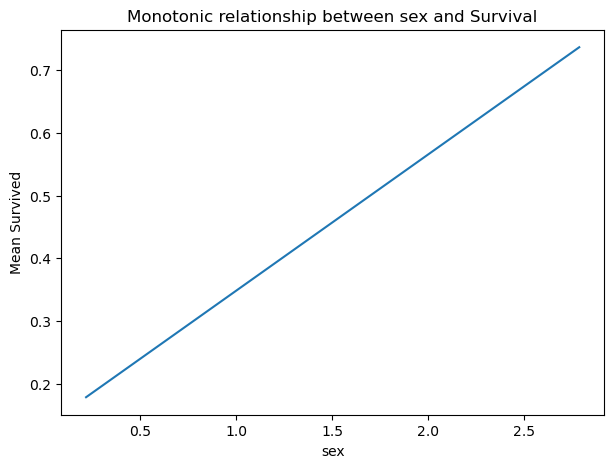

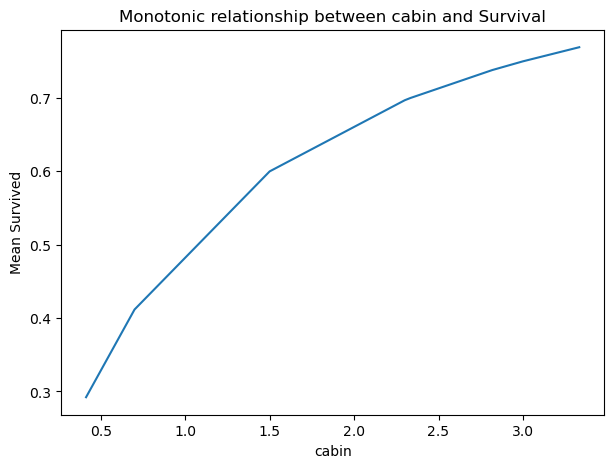

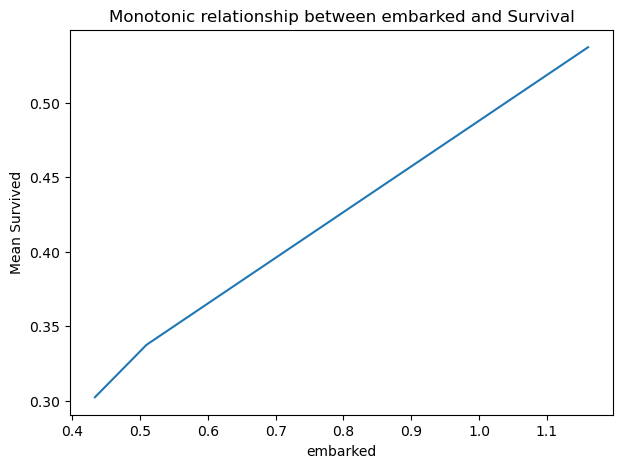

In [22]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target
for var in data.columns:
    if not var == 'survived':
        fig = plt.figure(figsize=(7,5))
        fig = X_train.groupby([var])['survived'].mean().plot()
        fig.set_title('Monotonic relationship between {} and Survival'.format(var))
        fig.set_ylabel('Mean Survived')
        plt.show()

Note the monotonic relationships between the mean target and the categories.

**Note**

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. 

In addition, it will create NA or Inf if the probability of target = 0 is zero, as the division by zero is not defined.